<a href="https://colab.research.google.com/github/betyavan/ML-practice/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображении

Решаем задачу сегментации медецинских снимков

Использую датасет ADDI project

## Загрузка и подготовка датасета

In [1]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 243MB/s] 


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [3]:
from skimage.io import imread
import os

In [4]:
images = []
lesions = []

root = 'PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
  if root.endswith("_Dermoscopic_Image"):
    images.append(imread(os.path.join(root, files[0])))
  if root.endswith('_lesion'):
    lesions.append(imread(os.path.join(root, files[0])))


Изображение имеют разные размеры, поэтому отресайзим их до 256х256

In [5]:
from skimage.transform import resize

In [6]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np

In [8]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

In [9]:
print(f'Loaded {len(X)} images')

Loaded 200 images


Орисуем несколько изображении

In [10]:
import matplotlib.pyplot as plt

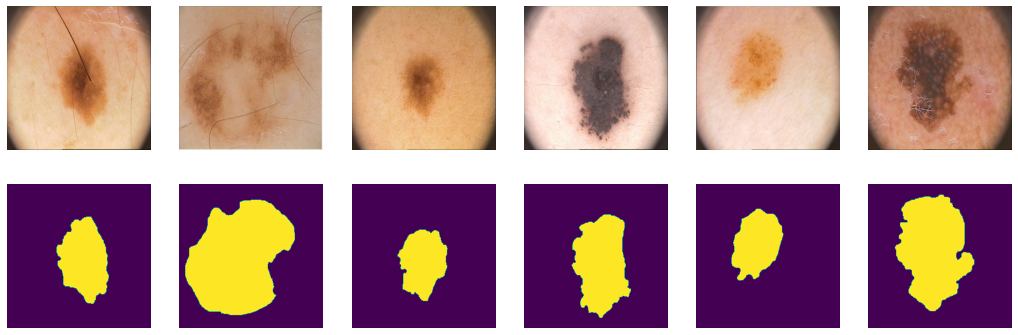

In [11]:
plt.figure(figsize=(18, 6))
for i in range(6):
  plt.subplot(2, 6, i + 1)
  plt.axis('off')
  plt.imshow(X[i])

  plt.subplot(2, 6, i + 7)
  plt.axis('off')
  plt.imshow(Y[i])

plt.show();

Всего 200 картинок

100 - обучение и по 50 на валидацию + тестирование

In [12]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [13]:
print(len(tr), len(val), len(ts))

100 50 50


Подготовим даталоадеры

In [14]:
from torch.utils.data import DataLoader

rollaxis нужен для того чтобы поменять поряд осей, так как в торче юзаем C, H, W

In [15]:
batch_size = 25

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                          batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                          batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                          batch_size=batch_size, shuffle=False)

In [16]:
import torch

In [17]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


# Реализация архитектур

## SegNet
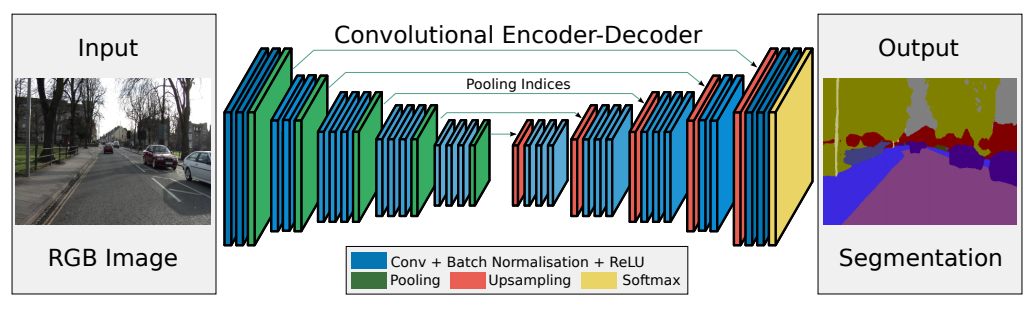


In [18]:
import torch
import torch.nn as nn
import torch.nn. functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

In [19]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.en_pool = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.dec_pool = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # encoder
        x, idx0 = self.en_pool(self.enc_conv0(x))
        x, idx1 = self.en_pool(self.enc_conv1(x))
        x, idx2 = self.en_pool(self.enc_conv2(x))
        x, idx3 = self.en_pool(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(self.dec_pool(x, idx3))
        x = self.dec_conv1(self.dec_pool(x, idx2))
        x = self.dec_conv2(self.dec_pool(x, idx1))
        x = self.dec_conv3(self.dec_pool(x, idx0)) # no activation
        return x

### Метрика IoU

In [20]:
def iou_pytorch(outputs: torch.tensor, labels: torch.Tensor):
  outputs = outputs.squeeze(1).byte() # BATCH x 1 x H x W => BATCH x H x W
  labels = labels.squeeze(1).byte()
  SMOOTH = 1e-8
  intersection = (outputs & labels).float().sum((1, 2))
  union = (outputs | labels).float().sum((1, 2))

  iou = (intersection + SMOOTH) / (union + SMOOTH)

  return iou

### Функция потерь

In [21]:
def bce_loss(y_real, y_pred):
  y_pred = torch.sigmoid(y_pred)
  return torch.mean(y_pred - torch.mul(y_pred, y_real) + torch.log(1 + torch.exp(-y_pred)))

### Тренировка

In [22]:
from IPython.display import clear_output

In [23]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
  X_val, Y_val = next(iter(data_val))

  for epoch in range(epochs):
    tic = time()
    print('* Epoch %d/%d' % (epoch + 1, epochs))
    avg_loss = 0.0
    model.train()
    for X_batch, Y_batch in data_tr:
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      optimizer.zero_grad()
      Y_pred = model(X_batch)
      loss = loss_fn(Y_pred, Y_batch)
      loss.backward()
      optimizer.step()

      avg_loss += loss.item() / len(data_tr)
    
    toc = time()
    print('loss: %f' % avg_loss)

    model.eval()
    Y_hat = model(X_val.to(device)).detach().cpu()
    torch.cuda.empty_cache()

    clear_output(wait=True)
    for k in range(6):
      plt.subplot(2, 6, k + 1)
      plt.axis('off')
      plt.title('Real')
      plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')

      plt.subplot(2, 6, k + 7)
      plt.axis('off')
      plt.imshow(Y[i])
      plt.title('Output')
      plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.suptitle('%d / %d - loss: %.4f' % (epoch +1, epochs, avg_loss))
    plt.show()

### Инференс

In [24]:
def predict(model, data):
  model.eval()
  preds = []
  for X_batch, Y_label in data:
      Y_pred = model(X_batch.to(device))
      Y_pred = (torch.sigmoid(Y_pred) >= 0.5).to(torch.long).detach().cpu()
      preds.append(Y_pred)
  return np.array(Y_pred)

In [25]:
def score_model(model, metric, data):
  model.eval()
  scores = 0.0
  for X_batch, Y_label in data:
      Y_pred = model(X_batch.to(device))
      Y_pred = (torch.sigmoid(Y_pred) >= 0.5).to(torch.long)
      scores += metric(Y_pred, Y_label.to(device)).mean().item()

  return scores / len(data)

### Обучение

In [29]:
model = SegNet().to(device)

In [30]:
max_epochs = 50
optim = torch.optim.Adam(model.parameters(), lr=3e-4)

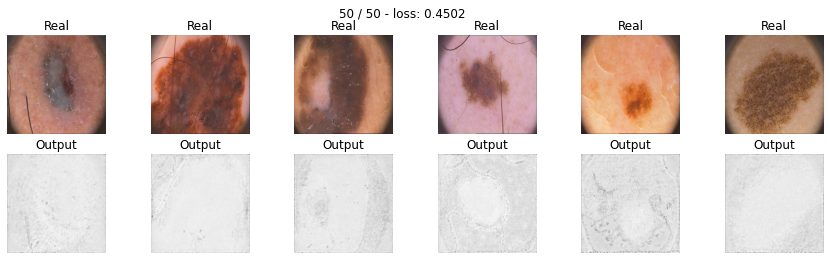

In [31]:
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [32]:
score_model(model, iou_pytorch, data_val)

0.37082335352897644

Модель похоже переобучилась

неудевительно, так как модель сложная, а данных мало

## U-Net

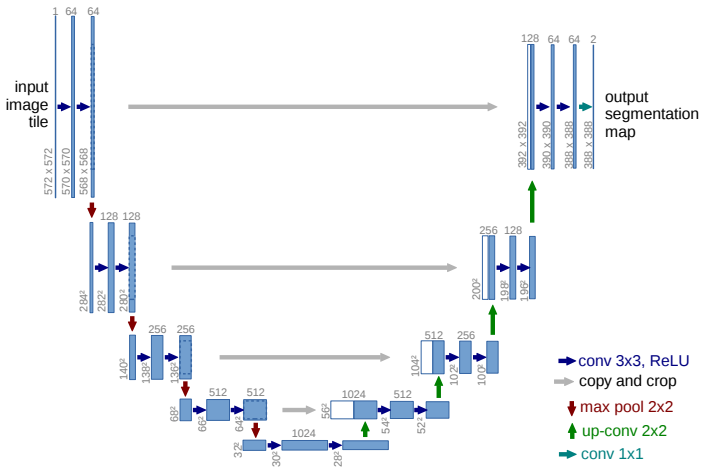

In [26]:
from torch.nn.modules.pooling import MaxUnpool2d
def double_conv(in_ch, out_ch, k_size=3):
  return nn.Sequential(
      nn.Conv2d(in_ch, out_ch, k_size, padding=1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(),
      nn.Conv2d(out_ch, out_ch, k_size, padding=1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU()
  )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.en_pool = nn.MaxPool2d(2, 2)

        self.enc_conv0 = double_conv(3, 64)
        self.enc_conv1 = double_conv(64, 128)
        self.enc_conv2 = double_conv(128, 256)
        self.enc_conv3 = double_conv(256, 512)

        # bottleneck
        self.bottleneck_conv = double_conv(512, 1024)

        # decoder (upsampling)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec_conv3 = double_conv(1024 + 512, 512)
        self.dec_conv2 = double_conv(256 + 512, 256)
        self.dec_conv1 = double_conv(256 + 128, 128)
        self.dec_conv0 = double_conv(128 + 64, 64)
        
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv0 = self.enc_conv0(x)
        x = self.en_pool(conv0)

        conv1 = self.enc_conv1(x)
        x = self.en_pool(conv1)

        conv2 = self.enc_conv2(x)
        x = self.en_pool(conv2)

        conv3 = self.enc_conv3(x)
        x = self.en_pool(conv3)

        x = self.bottleneck_conv(x)
              
        x = self.upsample(x) #!!!
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample(x)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv0(x)

        x = self.out(x)

        return x

In [27]:
unet_model = UNet().to(device)

In [28]:
torch.cuda.empty_cache()

In [29]:
opt = torch.optim.Adam(unet_model.parameters(), lr=3e-4)

In [30]:
loss_fn = nn.BCELoss()

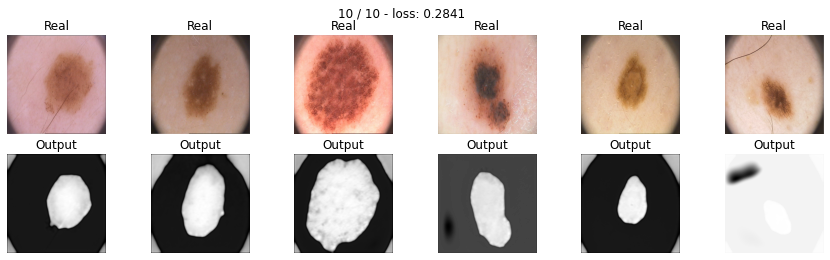

In [31]:
train(unet_model, opt, bce_loss, 10, data_tr, data_val)

In [32]:
score_model(unet_model, iou_pytorch, data_val)

0.3461182415485382

всего за 10 эпох результат сопоставим с SegNet